# Project 5 - 인물모드(아웃포커싱) 구현하기

In [1]:
import os
import urllib
import cv2

from pixellib.semantic import semantic_segmentation

import numpy as np
import matplotlib.pyplot as plt

### (0) segmentation model 준비

In [2]:
model_dir = './data/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file)

('./data/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f015982a580>)

In [3]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### (1) 이미지 불러오기

(720, 1280, 3)


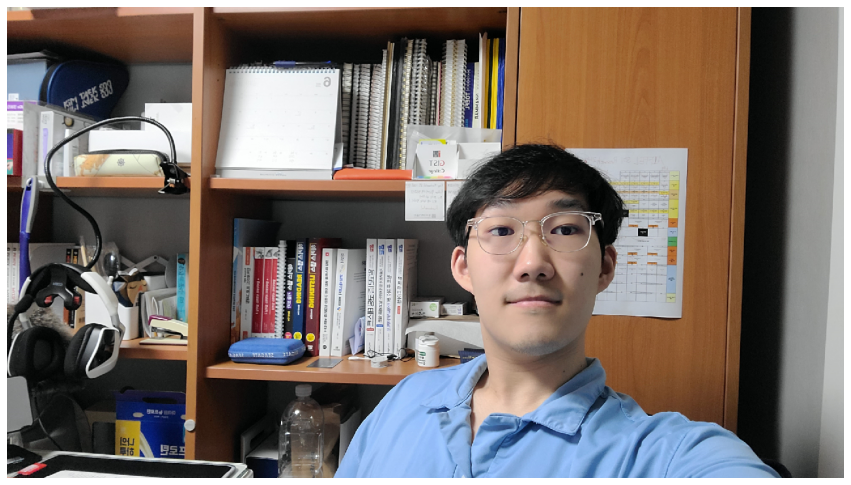

In [4]:
img_path = './data/images/self_camera.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### (2) semantic segmentation 수행

In [5]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

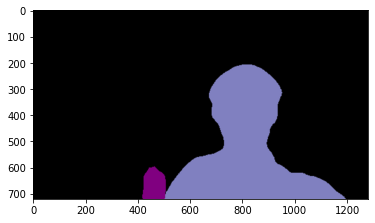

In [6]:
segvalues, output = model.segmentAsPascalvoc(img_path) # 분할 출력의 배열 가져오기

plt.imshow(output)
plt.show()

### (3) 사람, 배경 분리하기

In [7]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

In [8]:
print(segvalues['masks'].shape) # 각 픽셀의 마스크

for class_id in segvalues['class_ids']: # 이미지를 구성하는 class의 종류
    print(LABEL_NAMES[class_id], class_id)

(720, 1280)
background 0
bottle 5
person 15


In [9]:
colormap[15] # person, pacalvoc LABEL_NAMES 15번째

array([192, 128, 128])

In [10]:
seg_color = (128,128,192) # 색상순서 변경 - BGR2RGB

(720, 1280)


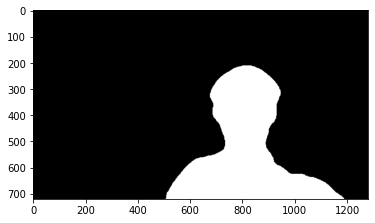

In [11]:
seg_map = np.all(output==seg_color, axis=-1) # person 영역을 제외한 나머지 black
print(seg_map.shape)

plt.imshow(seg_map, cmap='gray')
plt.show()

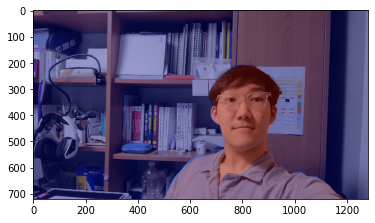

In [12]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255 # True -> 255, False -> 0

color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### (4) 배경 블러처리

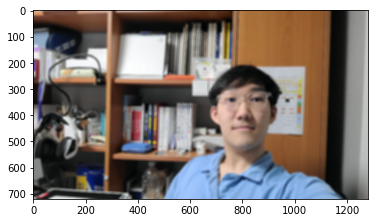

In [13]:
img_orig_blur = cv2.blur(img_orig, (11,11))

plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

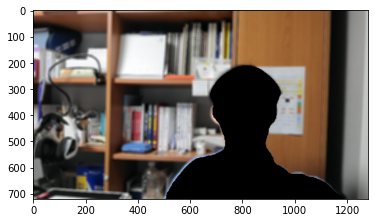

In [14]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 - 사람 마스크를 배경 마스크로 변환
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경만 남기기

plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### (5) 배경, 사람 합성

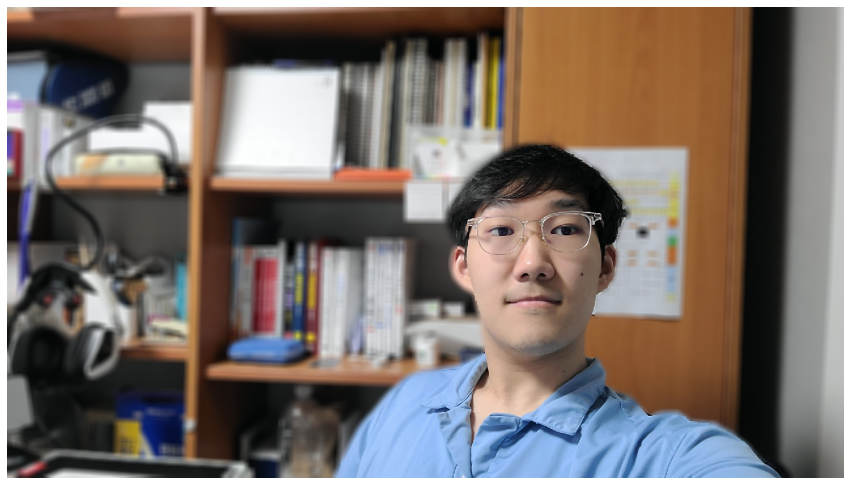

In [15]:
# mask가 255인 부분(사람) - 원본 이미지, 나머지 부분(배경) - 블러 이미지
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (6) 강아지 사진으로 인물모드 구현

(546, 650, 3)


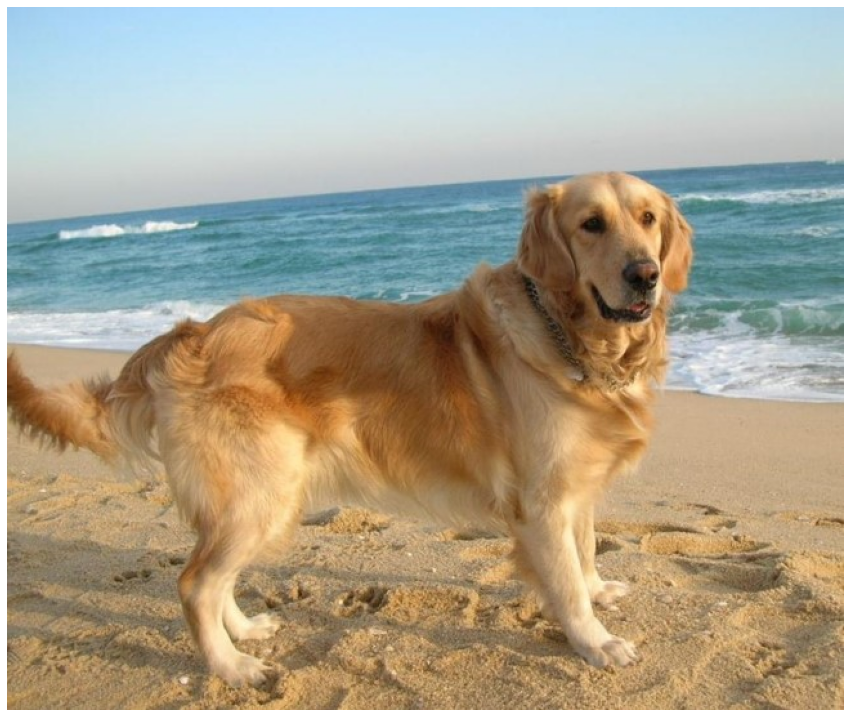

In [16]:
dog_img_path = './data/images/dog.png'  
dog_img_orig = cv2.imread(dog_img_path) 

print(dog_img_orig.shape)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(dog_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

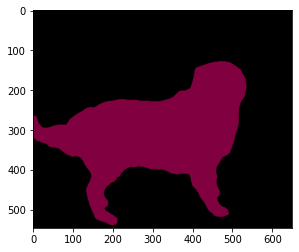

In [17]:
dog_segvalues, dog_output = model.segmentAsPascalvoc(dog_img_path) # 분할 출력의 배열 가져오기

plt.imshow(dog_output)
plt.show()

In [18]:
for class_id in dog_segvalues['class_ids']:
    print(LABEL_NAMES[class_id], class_id)

background 0
dog 12


In [19]:
colormap[12] # person, pacalvoc LABEL_NAMES 15번째

array([ 64,   0, 128])

In [20]:
dog_seg_color = (128,0,64) # 색상순서 변경 - BGR2RGB

(546, 650)


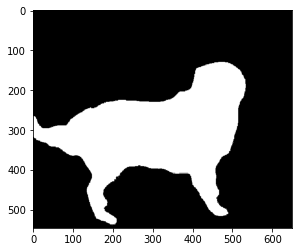

In [21]:
dog_seg_map = np.all(dog_output==dog_seg_color, axis=-1) # person 영역을 제외한 나머지 black
print(dog_seg_map.shape) 
plt.imshow(dog_seg_map, cmap='gray')
plt.show()

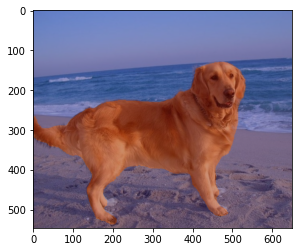

In [22]:
dog_img_show = dog_img_orig.copy()
dog_img_mask = dog_seg_map.astype(np.uint8) * 255 # True -> 255, False -> 0

dog_color_mask = cv2.applyColorMap(dog_img_mask, cv2.COLORMAP_JET)

dog_img_show = cv2.addWeighted(dog_img_show, 0.6, dog_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(dog_img_show, cv2.COLOR_BGR2RGB))
plt.show()

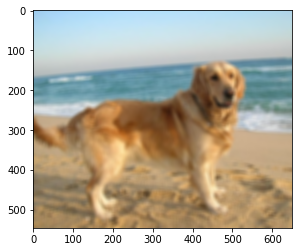

In [23]:
dog_img_orig_blur = cv2.blur(dog_img_orig, (11,11))

plt.imshow(cv2.cvtColor(dog_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

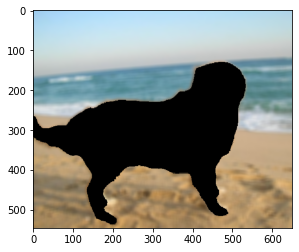

In [24]:
dog_img_mask_color = cv2.cvtColor(dog_img_mask, cv2.COLOR_GRAY2BGR)
dog_img_bg_mask = cv2.bitwise_not(dog_img_mask_color) # 이미지 반전 - 사람 마스크를 배경 마스크로 변환
dog_img_bg_blur = cv2.bitwise_and(dog_img_orig_blur, dog_img_bg_mask) # 배경만 남기기

plt.imshow(cv2.cvtColor(dog_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

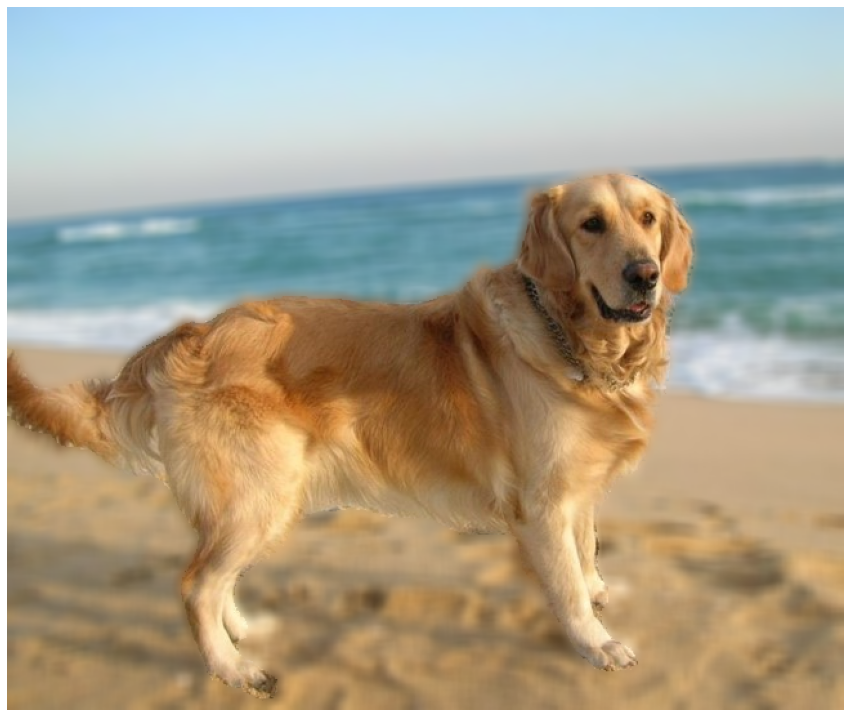

In [25]:
# mask가 255인 부분(사람) - 원본 이미지, 나머지 부분(배경) - 블러 이미지
dog_img_concat = np.where(dog_img_mask_color==255, dog_img_orig, dog_img_bg_blur)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(dog_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (7) 크로마키 배경 붙이기(바다)

(720, 1280, 3)


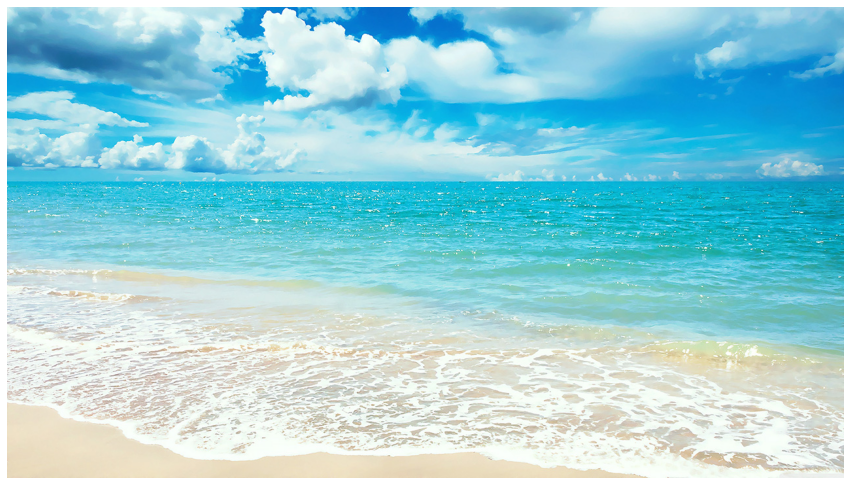

In [26]:
beach_img_path = './data/images/beach.png'
beach_img_orig = cv2.imread(beach_img_path)[80:, :]

print(beach_img_orig.shape)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(beach_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

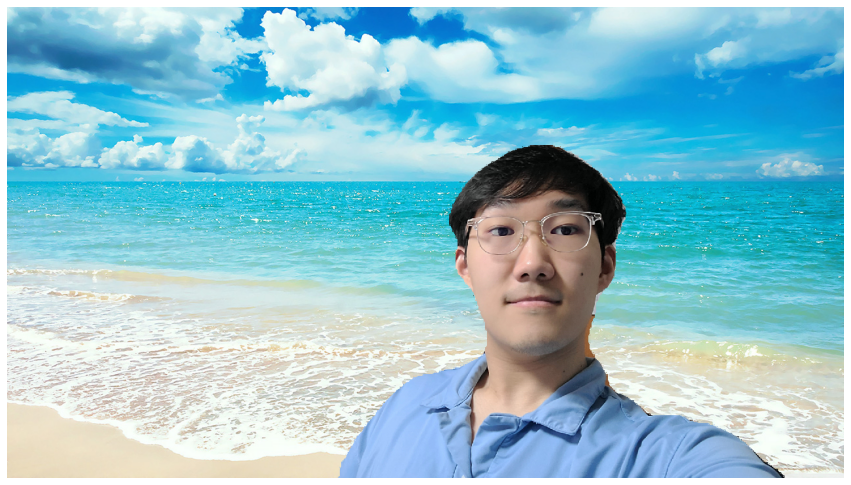

In [27]:
# mask가 255인 부분(사람) - 원본 이미지, 나머지 부분(배경) - 블러 이미지
beach_img_concat = np.where(img_mask_color==255, img_orig, beach_img_orig)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(beach_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (8) 구현한 인물모드 문제점

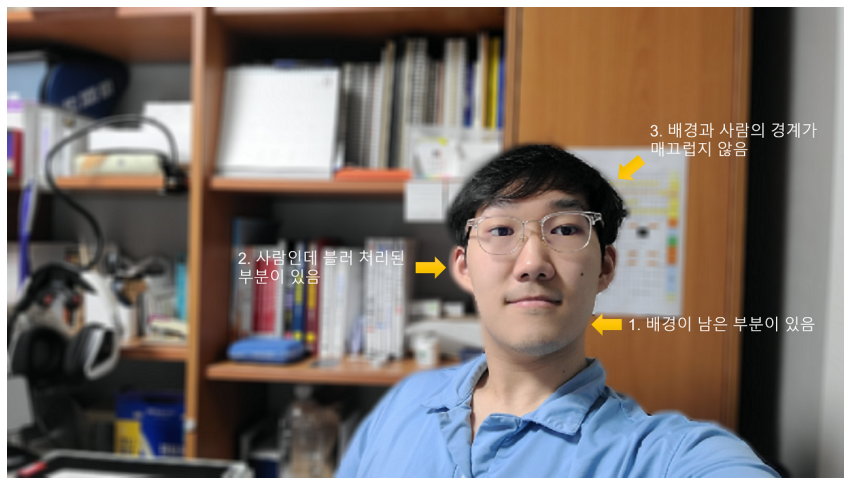

In [28]:
img_problem_path = './data/images/problem.png'
img_problem = cv2.imread(img_problem_path)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(img_problem, cv2.COLOR_BGR2RGB))
plt.show()

### (9) 문제점에 대한 해결책

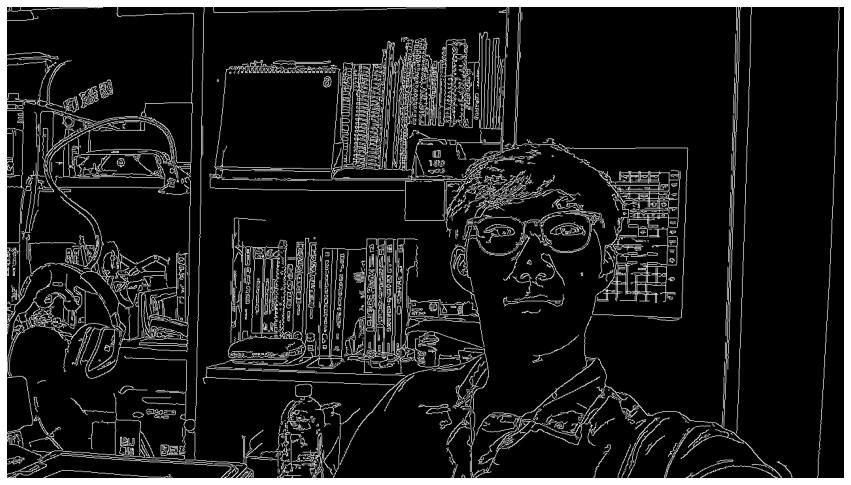

In [29]:
canny_img = cv2.Canny(img_orig, 50, 200)

plt.figure(figsize=(15,15)) # 이미지 크기 조정
plt.axis('off') # 축 없애기
plt.imshow(cv2.cvtColor(canny_img, cv2.COLOR_BGR2RGB))
plt.show()

Canny Edge detection은 thresholding을 이용하여 객체의 edge를 검출해내는 방식이다.  
이 방식은 굉장히 오래된 edge 검출 방식이고, 이후 edge 검출을 위해 많은 방식이 태어났다.

Edge를 잘 검출하게 되면 객체에 대한 segmentation이 수월해진다.  
이미지 상의 객체를 나누는 기준을 edge로 정하면 되기 때문이다.

Segmentation에서 가장 중요한 부분은 픽셀 단위에서 각 픽셀이 어느 객체에 속하는 지 확인하는 것이라고 생각한다.  
그리고 이를 위해 가장 중요하게 찾아야 하는 것은 edge 부분이라고 생각한다.

Edge를 찾는 또 다른 방법은 depth camera를 이용하는 방법이다.  
기존의 카메라는 이미지의 rgb 값의 차이로 edge를 구분했다면, depth camera는 거리의 차이로 edge를 구분할 수 있다.  
Edge를 검출하는 기법을 적절히 융합한다면 segmentation의 mask를 좀 더 확실하게 할 수 있을 것이라 생각한다.